Units used: GeV for masses, s for time, cm for distances

In [142]:
import os
import glob
import importlib

import matplotlib as mlib
import matplotlib.pyplot as plt

# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{slashed}"

import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
import TdAlps
from collections import OrderedDict

import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize

import csv

In [143]:
#Plotting settings

font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

In [144]:
def importNotebook(name):
    
    currentDir=os.getcwd()
    notebookDir=os.path.dirname(name)
    os.chdir(notebookDir)
    notebookName=os.path.basename(name).split('.')[0]
    module = importlib.import_module(f"ipynb.fs.full.{notebookName}")
    
    os.chdir(currentDir)
    
    globals().update(vars(module))

In [145]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_base.ipynb")

In [146]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_BRs.ipynb")

In [147]:
def getCsd(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return -coeffs['D'][1][0]+coeffs['d'][1][0]

### mass-coupling grid

In [148]:
#masslist= [0.05, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 2., 4.]
masslist=np.sort(np.append(np.logspace(-2, 0, 25),[0.09, 0.101, 0.43, 0.47,0.55,\
                                                   0.95, 1, 1.5, 2, 2.5, 3, 3.2, 3.5, 4,\
                                                   0.0935, 0.095, 0.63, 0.65]))
masslistShort=np.logspace(-2,np.log(2.1), 40)
masslistBaBArgammagamma=np.logspace(-1,0.4, 40)
particleCodes=[*range(0,7,1)]

In [149]:
masslistBaBArgammagamma

array([0.1       , 0.10861691, 0.11797633, 0.12814224, 0.13918414,
       0.15117751, 0.16420433, 0.17835367, 0.19372224, 0.21041511,
       0.22854639, 0.24824002, 0.26963063, 0.29286446, 0.31810032,
       0.34551073, 0.37528307, 0.40762087, 0.44274518, 0.48089613,
       0.52233451, 0.56734359, 0.61623107, 0.66933113, 0.72700678,
       0.78965229, 0.8576959 , 0.93160277, 1.01187812, 1.09907073,
       1.19377664, 1.29664328, 1.40837384, 1.52973212, 1.66154773,
       1.80472177, 1.96023298, 2.12914446, 2.31261088, 2.51188643])

In [150]:
couplingList=np.sort(np.append(np.logspace(-6, 4, 20),np.logspace(-1, 2, 20)))
couplingListShort=np.logspace(np.log(8*10**-4), np.log(1.7), 25)

In [151]:
couplingListSmallCouplings=np.sort(np.append(np.logspace(-7, 4, 20),np.logspace(-1, 2, 20)))

In [176]:
couplingListBeamDumpcWW=np.logspace(-3, 2, 20)
couplingListBeamDumpcff=np.logspace(-3, 2, 20)

In [153]:
couplingListBeamDumpcff

array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])

In [154]:
constants={
    'InvGeVtocm': 1/(5.06 * 10**(13))
}

In [155]:
sm['tauK+'] = 1.238*10**(-8)
sm['tauKL'] = 5.116*10**(-8)
sm['mKL'] = 497.611*10**(-3)

In [156]:
def f(Lambda):
    return Lambda/(4 * np.pi)

In [157]:
def formFactorFzeroKplus(qsqr): 
    #https://indico.cern.ch/event/769729/contributions/3512047/attachments/1905114/3146148/Kaon2019_MoulsonPassemarCorr.pdf
    l01 = 25.17
    l02 = 1.49
    f0 = 1.0012 * 0.216 #Christopher Smith's notes & 2107.14708
    return f0 * (1 + l01 * (qsqr/sm['mpi+']**2) + l02 * (qsqr/sm['mpi+'])**2) 
            #fplus(qsqr) + qsqr/(sm['mK+']**2-sm['mpi+']**2) fminus(qsqr)

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

### ALP and B-> Ka decay rates

In [158]:
# as in draft
def BrBtoKaplus(ma, cbs, Lambda):
    return (np.pi/4)*abs(cbs)**2/(Lambda**2) * abs(formFactorFzeroBplus(ma**2))**2 \
            * (sm['mB+']**2-sm['mK+']**2)**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4\
            -2*(sm['mB+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))\
            /sm['hbar']*sm['tauB+']

In [159]:
# as in draft
def BrKtoPiaplus(ma, csd, Lambda):
    return (np.pi/4)* abs(csd)**2/(Lambda**2) * abs(formFactorFzeroKplus(ma**2))**2 \
            * (sm['mK+']**2-sm['mpi+']**2)**2/sm['mK+']**3 * np.sqrt(sm['mK+']**4+sm['mpi+']**4+ma**4\
            -2*(sm['mpi+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mpi+']**2))\
            /sm['hbar']*sm['tauK+']

In [160]:
def BrKLtoPi0a(ma, csd, Lambda):
    return (np.pi/4)* abs(csd)**2/(Lambda**2) * abs(formFactorFzeroKplus(ma**2))**2 \
            * (sm['mKL']**2-sm['mpi0']**2)**2/sm['mKL']**3 * np.sqrt(sm['mKL']**4+sm['mpi0']**4+ma**4\
            -2*(sm['mpi0']**2 * sm['mKL']**2 + sm['mKL']**2 * ma**2 + ma**2 * sm['mpi0']**2))\
            /sm['hbar']*sm['tauKL']

### ALP branching ratios

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

In [161]:
def brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        brs = [[],[],[],[],[],[],[],[],[]]
        
        if (lscsPassed is not None):
            lscs=lscsPassed
        else:
            if ma<1:
                mu = 1
            else:
                mu=ma
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)
        
#         print("mu= ",mu)
#         print("readCee= ",readCee(lscs),", readCmumu= ",readCmumu(lscs))
#         print([ma,readCee(lscs),sm['me'],Lambda])
#         print("Gamma_ll= ",Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        
        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]\
                      +brs[6][-1]+brs[7][-1])
            

#         print("br[0][-1]= ",brs[0][-1])
        
        ctauAlp=constants['InvGeVtocm']/brs[8][-1]

        return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]

In [162]:
def brALPtoOneFinalStateCheck(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None,looporder=3,br=True):
#     with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

#         maList = list((i*10**(exp-2) for exp in range(-3, 2) for i in range(10, 100)))
        brs = [[],[],[],[],[],[],[],[],[]]
        if ma<1:
            mu = 1
        else:
            mu=ma
        lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, looporder)
        print("mu= ",mu)
        print("readCee= ",readCee(lscs),", readCmumu= ",readCmumu(lscs))
        print([ma,readCee(lscs),sm['me'],Lambda])
        print("Gamma_ll= ",Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))

        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]\
                      +brs[6][-1]+brs[7][-1])

        print("br[0][-1]= ",brs[0][-1])

        ctauAlp=constants['InvGeVtocm']/brs[8][-1]

        return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]

In [21]:
brALPtoOneFinalState(0.1,5,1,-1,-1,1,-1,0,0,0,4*np.pi*4*np.pi*10**3,lscsPassed=None)

/home/stasya/prj/alps-running/TdAlps-Internal/HighRunning.py:108: RuntimeWarning: invalid value encountered in sqrt
  g1 = np.sqrt(5 / 3 * a1 * (4 * p['PI']))


[0.04759603249364804, 562396551.3552603]

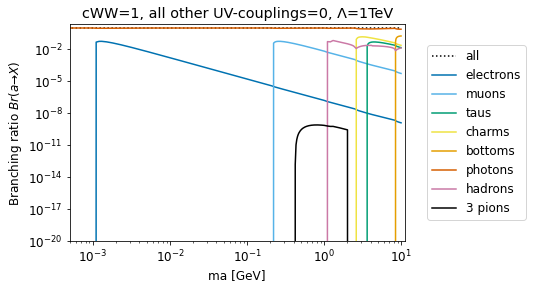

In [22]:
brsALP(0,0,0,0,0,0,1,0,"cWW=1, all other UV-couplings=0, \u039B=1TeV",1000,lower=10**-20)

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

### Effective coupling

no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/
no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/
no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/
no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/
no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/
no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/
no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/
no valid value for the low 

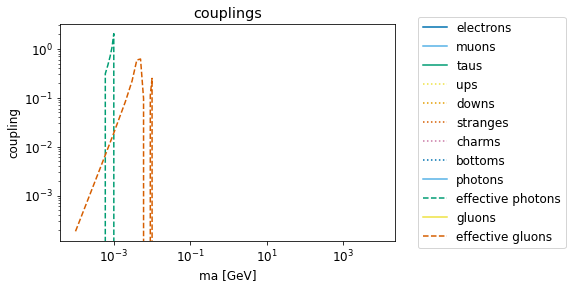

In [23]:
couplingRunning(1,1,1,1,1,0,0,0,'couplings',4*np.pi*1000,looporder=3)

In [163]:
def couplingRunningList(ma,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,looporder=3): #ma in GeV
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        coupls = [[],[],[],[],[],[],[],[],[],[],[],[]]
        if ma<1:
            mu = 1
        else:
            mu=ma
        lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, looporder)
        try:
            cee = readCee(lscs).real
        except IndexError:
            cee = 0
        except KeyError:
            cee = readCeeHS(lscs).real
        coupls[0].append(cee)
        try:
            cmumu = readCmumu(lscs).real
        except IndexError:
            cmumu = 0
        except KeyError:
            cmumu = readCmumuHS(lscs).real
        coupls[1].append(cmumu)
        try:
            ctautau = readCtautau(lscs).real
        except IndexError:
            ctautau = 0
        except KeyError:
            ctautau = readCtautauHS(lscs).real
        coupls[2].append(ctautau)
        try:
            cuu = readCuu(lscs).real
        except IndexError:
            cuu = 0
        except KeyError:
            cuu = readCuuHS(lscs).real
        coupls[3].append(cuu)
        try:
            cdd = readCdd(lscs).real
        except IndexError:
            cdd = 0
        except KeyError:
            cdd = readCddHS(lscs).real
        coupls[4].append(cdd)
        try:
            css = readCss(lscs).real
        except IndexError:
            css = 0
        except KeyError:
            css = readCssHS(lscs).real
        coupls[5].append(css)
        try:
            ccc = readCcc(lscs).real
        except IndexError:
            ccc = 0
        except KeyError:
            ccc = readCccHS(lscs).real
        coupls[6].append(ccc)
        try:
            cbb = readCbb(lscs).real
        except IndexError:
            cbb = 0
        except KeyError:
            cbb = readCbbHS(lscs).real
        coupls[7].append(cbb)
        try:
            cgamgam = readCgg(lscs).real
        except KeyError:
            cgamgam = 0
        coupls[8].append(cgamgam)
        effcgg = cgamgam
        if ma >= sm['mZ']:
            try:
                effcgg += 2 * readAlphaEM(lscs)/math.pi * lscs['WW']/sm['sw']**2 * B2(4*sm['mW']**2/ma**2)
            except:
#                 print(lscs)
                pass
            try:    
                effcgg += 3 * (2/3)**2 * readCtt(lscs) * B1(4*sm['mt']**2/ma**2)
            except KeyError:
                effcgg += 3 * (2/3)**2 * readCttHS(lscs) * B1(4*sm['mt']**2/ma**2)

        if ma >= sm['mc']:
            effcgg += 3 * (2/3)**2 * ccc * B1(4*sm['mc']**2/ma**2) 
        if ma >= sm['mb']:
            effcgg += 3 * (-1/3)**2 * cbb * B1(4*sm['mb']**2/ma**2)
        if ma >= 1:
            effcgg += 3 * (2/3)**2 * cuu * B1(4*sm['mu']**2/ma**2)
            effcgg += 3 * (-1/3)**2 * cdd * B1(4*sm['md']**2/ma**2)
            effcgg += 3 * (-1/3)**2 * css * B1(4*sm['ms']**2/ma**2)
        if ma >= sm['me']:
            effcgg += cee * B1(4*sm['me']**2/ma**2)
        if ma >= sm['mmu']:
            effcgg += cmumu * B1(4*sm['mmu']**2/ma**2)
        if ma >= sm['mtau']:
            effcgg += ctautau * B1(4*sm['mtau']**2/ma**2)
        if ma <= 1:
            tmp = -(5/3 + sm['mpi+']**2/(sm['mpi+']**2-ma**2) * (sm['md']-sm['mu'])/(sm['md']+sm['mu']))*readCGG(lscs)
            tmp += -ma**2/(sm['mpi+']**2-ma**2) * (cuu - cdd)/2
            effcgg += tmp

        coupls[9].append(effcgg) # effective photon coupling
        coupls[10].append(readCGG(lscs).real)

        cGGeff = readCGG(lscs).real
        cGGeff += 1/2 * cuu * B1(4*sm['mu']**2/ma**2)
        cGGeff += 1/2 * cdd * B1(4*sm['md']**2/ma**2)
        cGGeff += 1/2 * css * B1(4*sm['ms']**2/ma**2)
        cGGeff += 1/2 * ccc * B1(4*sm['mc']**2/ma**2)
        cGGeff += 1/2 * cbb * B1(4*sm['mb']**2/ma**2)
        try:
            cGGeff += 1/2 * readCtt(lscs) * B1(4*sm['mt']**2/ma**2)
        except:
            pass
        coupls[11].append(cGGeff)

        return coupls


In [164]:
couplingRunningList(2,1,1,1,1,1,0,0,0,4*np.pi*1000,looporder=3)[9][0]

(-7.082944864637565+0.28006150885088954j)

## Generate Beam dump files [ma, tau, c, ceff]

In [165]:
#converting g_a\gamma in 1904.02091 to C_\gamma\gamma in our case (or eqv. in 2012.12272)
def cggBeamDumpToOurs(Lambda):
    return Lambda/(4*1/137)

In [166]:
cggBeamDumpToOurs(1000)*10**-6

0.034249999999999996

In [167]:
cggBeamDumpToOurs(1000)*10**-3

34.25

In [201]:
# NuCalCHARMBounds=genfromtxt('../Experimental_files/NuCal-CHARM.txt', delimiter='\t')
NuCalCHARMBoundsUpper=genfromtxt('../Experimental_files/NuCal-CHARM_upper.txt', delimiter='\t')
NuCalCHARMBoundsLowerData=genfromtxt('../Experimental_files/NuCal-CHARM_lower.txt', delimiter='\t')

In [191]:
# NuCalCHARMBounds=genfromtxt('../Experimental_files/NuCal-CHARM.txt', delimiter='\t')
NuCalCHARME137BoundsUpper=genfromtxt('../Experimental_files/NuCal-CHARM-E137_upper.txt', delimiter='\t')
NuCalCHARME137BoundsLowerData=genfromtxt('../Experimental_files/NuCal-CHARM-E137_lower.txt', delimiter='\t')

In [193]:
#calculating NuCalCHARMBoundsLower on the mass grid of NuCalCHARMBoundsUpper
NuCalCHARMBoundsLower=np.array([NuCalCHARMBoundsUpper[:,0],\
                                np.interp(NuCalCHARMBoundsUpper[:,0],NuCalCHARMBoundsLowerData[:,0],\
                                NuCalCHARMBoundsLowerData[:,1])]).T

NuCalCHARME137BoundsLower=np.array([NuCalCHARME137BoundsUpper[:,0],\
                                np.interp(NuCalCHARME137BoundsUpper[:,0],NuCalCHARME137BoundsLowerData[:,0],\
                                NuCalCHARME137BoundsLowerData[:,1])]).T

In [170]:
#effectiveCoupling = (9,11) for (photons, gluons)
def generateBeamDumpFiles(expArrayUpper,expArrayLower,clist,effectiveCoupling,process,Lambda):
    
    with HiddenPrints():
    
        BeamDumpList=[['# m [GeV], tau [ps], c, c_eff(theo), c_eff(exp)^upper,  c_eff(exp)^lower,\
        c_eff(exp)^upper converted,  c_eff(exp)^lower converted, allowed/excluded (1/0)']]

        for i in range(len(expArrayUpper[:,0])):
            ma=expArrayUpper[i,0]
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-cexpArrayUpper[:,0]
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c


                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12
                ceffTheo=abs(couplingRunningList(ma,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,looporder=3)\
                [effectiveCoupling][0])
                
                if (ceffTheo<=expArrayUpper[i,1]*cggBeamDumpToOurs(Lambda))&\
                (ceffTheo>=expArrayLower[i,1]*cggBeamDumpToOurs(Lambda)):
                    allowedExcluded=0
                else: allowedExcluded=1
                

                BeamDumpList.append([ma,tau,c,ceffTheo,expArrayUpper[i,1],\
                                     expArrayLower[i,1],expArrayUpper[i,1]*cggBeamDumpToOurs(Lambda),\
                                     expArrayLower[i,1]*cggBeamDumpToOurs(Lambda), allowedExcluded])
        return BeamDumpList

In [202]:
meshcWWNuCalCHARM=generateBeamDumpFiles(NuCalCHARMBoundsUpper,NuCalCHARMBoundsLower,\
                                        couplingListBeamDumpcWW,9,'cWW',1000)

meshcffNuCalCHARM=generateBeamDumpFiles(NuCalCHARMBoundsUpper,NuCalCHARMBoundsLower,\
                                        couplingListBeamDumpcff,9,'cff',1000)

In [203]:
with open("output/m-tau-c-NuCal-CHARM-cWW_combined.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWWNuCalCHARM)
    
with open("output/m-tau-c-NuCal-CHARM-cff_combined.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcffNuCalCHARM)

In [194]:
meshcWWNuCalCHARME137=generateBeamDumpFiles(NuCalCHARME137BoundsUpper,NuCalCHARME137BoundsLower,\
                                        couplingListBeamDumpcWW,9,'cWW',1000)

meshcffNuCalCHARME137=generateBeamDumpFiles(NuCalCHARME137BoundsUpper,NuCalCHARME137BoundsLower,\
                                        couplingListBeamDumpcff,9,'cff',1000)

/home/stasya/prj/alps/Python/ALPs_base.ipynb:694: ComplexWarning: Casting complex values to real discards the imaginary part
  "    alphaEM = readAlphaEM(coeffs)\n",
/home/stasya/prj/alps/Python/ALPs_base.ipynb:681: ComplexWarning: Casting complex values to real discards the imaginary part
  "    return float(gamma)\n",


In [197]:
with open("output/m-tau-c-NuCal-CHARM-E137-cWW_combined.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWWNuCalCHARME137)
    
with open("output/m-tau-c-NuCal-CHARM-E137-cff_combined.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcffNuCalCHARME137)

## Generate [ma, tau, c, BR(theory)] files for Na62 and KOTO (KOTO gives incorrect results)

In [27]:
Na62Bounds=genfromtxt('../Experimental_files/Na62-BR_m_tau_2103.15389-h.csv', delimiter=',')

In [28]:
BaBargammagammaBoundsRaw=[genfromtxt('../Experimental_files/BaBr_gamma-gamma_ctau0mm.dat', delimiter='\t'),\
                      genfromtxt('../Experimental_files/BaBr_gamma-gamma_ctau1mm.dat', delimiter='\t'),\
                      genfromtxt('../Experimental_files/BaBr_gamma-gamma_ctau10mm.dat', delimiter='\t'),\
                      genfromtxt('../Experimental_files/BaBr_gamma-gamma_ctau100mm.dat', delimiter='\t')]

In [64]:
KOTOBounds=genfromtxt('../Experimental_files/KOTO.txt', delimiter='\t')

In [29]:
BaBargammagammaBounds=[masslistBaBArgammagamma]
for bound in BaBargammagammaBoundsRaw: 
    BaBargammagammaBounds.append(np.interp(masslistBaBArgammagamma,\
                                           bound[:,0], bound[:,1]))
BaBargammagammaBounds=np.array(BaBargammagammaBounds).T

In [30]:
BaBargammagammaBounds.shape

(40, 5)

In [31]:
Na62Bounds.shape

(66, 8)

In [32]:
np.interp(masslistBaBArgammagamma, bound[:,0], bound[:,1])

array([2.00460000e-06, 2.00460000e-06, 2.00460000e-06, 2.00460000e-06,
       2.00460000e-06, 2.00460000e-06, 2.00460000e-06, 2.00460000e-06,
       2.00460000e-06, 2.00460000e-06, 1.41581029e-06, 1.74594129e-06,
       1.73866492e-06, 1.36555692e-06, 1.08172158e-06, 1.36387606e-06,
       1.22668715e-06, 9.02840585e-07, 5.16122027e-07, 5.50359257e-07,
       5.87546677e-07, 6.27938504e-07, 6.71810857e-07, 1.08456137e-06,
       1.28595773e-06, 1.06656752e-06, 6.08273142e-07, 4.31143373e-07,
       3.69014135e-07, 6.50665025e-07, 1.06994031e-06, 5.00472906e-07,
       2.78868578e-07, 4.07119341e-07, 1.50171695e-07, 2.25444841e-07,
       4.20462459e-07, 3.19753474e-07, 2.73476238e-07, 2.01210000e-07])

In [33]:
couplingListSmallCouplings

array([1.00000000e-07, 3.79269019e-07, 1.43844989e-06, 5.45559478e-06,
       2.06913808e-05, 7.84759970e-05, 2.97635144e-04, 1.12883789e-03,
       4.28133240e-03, 1.62377674e-02, 6.15848211e-02, 1.00000000e-01,
       1.43844989e-01, 2.06913808e-01, 2.33572147e-01, 2.97635144e-01,
       4.28133240e-01, 6.15848211e-01, 8.85866790e-01, 8.85866790e-01,
       1.27427499e+00, 1.83298071e+00, 2.63665090e+00, 3.35981829e+00,
       3.79269019e+00, 5.45559478e+00, 7.84759970e+00, 1.12883789e+01,
       1.27427499e+01, 1.62377674e+01, 2.33572147e+01, 3.35981829e+01,
       4.83293024e+01, 4.83293024e+01, 6.95192796e+01, 1.00000000e+02,
       1.83298071e+02, 6.95192796e+02, 2.63665090e+03, 1.00000000e+04])

In [34]:
def generateNa62Files(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        Na62List=[['# m [GeV], tau [ps], c, BR_theo(K+->pi+ a)\n']]

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c

#                 coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)

                csd=getCsd(cff, cWW, cBB, Lambda, sm['mK+'])
    
#                 print(csd)

                BR= BrKtoPiaplus(ma, csd, Lambda)
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                Na62List.append([ma,tau,c,BR])
        return Na62List

In [35]:
def generateBaBargammagammaFiles(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        BaBargammagammaList=[['# m [GeV], tau [ps], c, BR_theo(B+->K+ a)*BR_theo(a-> gamma gamma)\n']]

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c

#                 coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)

                cbs=getCbs(cff, cWW, cBB, Lambda, sm['mB+'])
                coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)
    
#                 print(csd)


#                 print([ma,5,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda])        
#                 print(brALPtoOneFinalState(ma,5,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0])
                BR= BrBtoKaplus(ma, cbs, Lambda)\
                    *brALPtoOneFinalState(ma,5,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0]
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                BaBargammagammaList.append([ma,tau,c,BR])
        return BaBargammagammaList

In [206]:
100/sm['c']*10**12

3335.6409519815206

In [62]:
def generateKOTOFiles(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        KOTOList=[['# m [GeV], tau [ps], c, BR_theo(KL->pi0 a)\n']]

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c

#                 coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)

                csd=getCsd(cff, cWW, cBB, Lambda, sm['mK+'])
    
#                 print(csd)

                BR= BrKtoPiaplus(ma, csd, Lambda)
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                KOTOList.append([ma,tau,c,BR])
        return KOTOList

In [36]:
meshcWW=generateNa62Files(Na62Bounds[:,0] * 10**-3,couplingListSmallCouplings,'cWW',4*np.pi*10**3)
meshcff=generateNa62Files(Na62Bounds[:,0] * 10**-3,couplingListSmallCouplings,'cff',4*np.pi*10**3)

In [37]:
meshcWWBaBar=generateBaBargammagammaFiles(BaBargammagammaBounds[:,0],\
                                          couplingListSmallCouplings,'cWW',4*np.pi*10**3)
meshcffBaBar=generateBaBargammagammaFiles(BaBargammagammaBounds[:,0],\
                                          couplingListSmallCouplings,'cff',4*np.pi*10**3)

In [65]:
meshcWWKOTO=generateKOTOFiles(KOTOBounds[:,0] * 10**-3,couplingListSmallCouplings,'cWW',4*np.pi*10**3)
meshcffKOTO=generateKOTOFiles(KOTOBounds[:,0] * 10**-3,couplingListSmallCouplings,'cff',4*np.pi*10**3)

/home/stasya/prj/alps/Python/ALPs_base.ipynb:641: ComplexWarning: Casting complex values to real discards the imaginary part
  "\n",


In [39]:
with open("output/m-tau-c-BRBtoKgammagamma-cWW.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWWBaBar)
    
with open("output/m-tau-c-BRBtoKgammagamma-cff.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcffBaBar)

In [38]:
# with open("output/m-tau-c-BRBtoKmumu-cffcWWcBB.dat", "w", newline="") as f:
#     writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
#     writer.writerows(meshcffcWWcBB)
    
with open("output/m-tau-c-BRKtoPia-cWW.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWW)
    
with open("output/m-tau-c-BRKtoPia-cff.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcff)

In [66]:
with open("output/m-tau-c-BRKLtoPi0a-cWW.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWWKOTO)
    
with open("output/m-tau-c-BRKLtoPi0a-cff.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcffKOTO)

### interpolating Na62 files in lifetime and comparing to theo files

In [40]:
tauListNa62 = 10**12*np.array([np.Inf, 5*10**-9, 2*10**-9, 1*10**-9, 500*10**(-12), 200*10**(-12),\
                      100*10**(-12),]) # [tau] = ps
tauListBaBargammagamma = 10**12/(3*10**11)*np.array([0,1,10,100]) # [tau] = ps

In [41]:
tauListNa62

array([  inf, 5000., 2000., 1000.,  500.,  200.,  100.])

In [42]:
tauListBaBargammagamma

array([  0.        ,   3.33333333,  33.33333333, 333.33333333])

In [43]:
def compareTheoExpNA62(coupling):
    theoList = genfromtxt('output/m-tau-c-BRKtoPia-{}.dat'.format(coupling), delimiter=',')
#     print(theoList[0])
    
    allowedlist=[['# m [GeV], tau [ps], c, BR_theo(K+->pi+ a), BR_Na62(K+->pi+ a), Allowed/excluded (1/0)\n']]
    for i in range(0,theoList.shape[0]):
        #picking mass and tau from theo file
        ma = theoList[i,0]
        taua = theoList[i,1]
        
        # finding the same mass in exp file
        expPosition=np.where((Na62Bounds[:,0]/1000 >= ma*(1-0.0001))&(Na62Bounds[:,0]/1000 <= ma*(1+0.0001)))
    
        #interpolating BRexp so we get it for tau from out theo file
        BRexp=np.interp(taua,tauListNa62,Na62Bounds[expPosition,1:][0,0])

        # comparing theo and exp bounds (1 = allowed, 0 = excluded)
        if BRexp<=theoList[i,3]:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,0])
        else:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,1])

        # writing results into a file
        with open("output/m-tau-c-BRKLtoPi0a-{}_combined.dat".format(coupling), "w", newline="") as f:
            writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
            writer.writerows(allowedlist)
        

In [45]:
compareTheoExpNA62("cWW")
compareTheoExpNA62("cff")

In [46]:
def compareTheoExpBaBargammagamma(coupling):
    theoList = genfromtxt('output/m-tau-c-BRBtoKgammagamma-{}.dat'.format(coupling), delimiter=',')
#     print(theoList[0])
    
    allowedlist=[['# m [GeV], tau [ps], c, BR_theo(B+->K+ a)*BR_theo(a-> gamma gamma),\
    BR_BaBar(B+->K+ a)*BR_BaBar(a-> gamma gamma), Allowed/excluded (1/0)\n']]
    for i in range(0,theoList.shape[0]):
        #picking mass and tau from theo file
        ma = theoList[i,0]
        taua = theoList[i,1]
        
#         print(ma)
#         print(taua)
#         print(BaBargammagammaBounds[:,0])
        
        # finding the same mass in exp file
        expPosition=np.where((BaBargammagammaBounds[:,0] >= ma*(1-0.0001))\
                             &(BaBargammagammaBounds[:,0] <= ma*(1+0.0001)))
        
#         print(expPosition)
        #interpolating BaBar's BRexp in tau and mass
        BRexp=np.interp(taua,tauListBaBargammagamma,BaBargammagammaBounds[expPosition,1:][0,0])

        # comparing theo and exp bounds (1 = allowed, 0 = excluded)
        if BRexp<=theoList[i,3]:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,0])
        else:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,1])

        # writing results into a file
        with open("output/m-tau-c-BRBtoKgammagamma-{}_combined.dat".format(coupling), "w", newline="") as f:
            writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
            writer.writerows(allowedlist)
        

In [47]:
compareTheoExpBaBargammagamma("cWW")
compareTheoExpBaBargammagamma("cff")

In [80]:
def compareTheoExpKOTO(coupling):
    theoList = genfromtxt('output/m-tau-c-BRKLtoPi0a-{}.dat'.format(coupling), delimiter=',')
#     print(theoList[0])
    
    allowedlist=[['# m [GeV], tau [ps], c, BR_theo(KL->pi0 a), BR_KOTO(KL->pi0 a), Allowed/excluded (1/0)\n']]
    for i in range(0,theoList.shape[0]):
        #picking mass and tau from theo file
        ma = theoList[i,0]
        taua = theoList[i,1]
        
        # finding the same mass in exp file
        expPosition=np.where((KOTOBounds[:,0]/1000 >= ma*(1-0.0001))&(KOTOBounds[:,0]/1000 <= ma*(1+0.0001)))
    
        BRexp=KOTOBounds[expPosition,1]
#         print(BRexp[0,0])

        # comparing theo and exp bounds (1 = allowed, 0 = excluded)
        if BRexp<=theoList[i,3]:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,0])
        else:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,1])

        # writing results into a file
        with open("output/m-tau-c-BRKLtoPi0a-{}_combined.dat".format(coupling), "w", newline="") as f:
            writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
            writer.writerows(allowedlist)

In [75]:
KOTOBounds[2,1]

2.2828e-09

In [81]:
compareTheoExpKOTO("cWW")
compareTheoExpKOTO("cff")

### importing bounds 

In [48]:
Na62BoundscWW = genfromtxt('output/m-tau-c-BRKtoPia-cWW_combined.dat', delimiter=',')
Na62Boundscff = genfromtxt('output/m-tau-c-BRKtoPia-cff_combined.dat', delimiter=',')

In [49]:
#from 2111.01800
BaBargammagammaBoundscWW = genfromtxt('output/m-tau-c-BRBtoKgammagamma-cWW_combined.dat', delimiter=',')
BaBargammagammaBoundscff = genfromtxt('output/m-tau-c-BRBtoKgammagamma-cff_combined.dat', delimiter=',')

In [69]:
KOTOBoundscWW = genfromtxt('output/m-tau-c-BRKLtoPi0a-cWW_combined.dat', delimiter=',')
KOTOBoundscff = genfromtxt('output/m-tau-c-BRKLtoPi0a-cff_combined.dat', delimiter=',')

In [124]:
NuCalCHARMBoundscWW = genfromtxt('output/m-tau-c-NuCal-CHARM-cWW_combined.dat', delimiter=',')
NuCalCHARMBoundscff = genfromtxt('output/m-tau-c-NuCal-CHARM-cff_combined.dat', delimiter=',')

In [70]:
KOTOBoundscWW

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 4.99267819e-24,
                   nan, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.79269019e-07, 7.18171738e-23,
                   nan, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.43844989e-06, 1.03305406e-21,
                   nan, 1.00000000e+00],
       ...,
       [2.60040000e-01, 1.73188631e-03, 6.95192796e+02, 1.17080588e+00,
                   nan, 0.00000000e+00],
       [2.60040000e-01, 1.20354669e-04, 2.63665090e+03, 1.68359685e+01,
                   nan, 0.00000000e+00],
       [2.60040000e-01, 8.36787029e-06, 1.00000000e+04, 2.42546344e+02,
                   nan, 0.00000000e+00]])

In [51]:
Na62Boundscff

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 4.90657238e-19,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.79269019e-07, 7.05785850e-18,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.43844989e-06, 1.01523758e-16,
        2.02000000e-10, 1.00000000e+00],
       ...,
       [2.60000000e-01, 4.28908073e-09, 6.95192796e+02, 1.15485186e+05,
        1.24000000e-10, 0.00000000e+00],
       [2.60000000e-01, 2.98173802e-10, 2.63665090e+03, 1.66119652e+06,
        1.24000000e-10, 0.00000000e+00],
       [2.60000000e-01, 2.07288280e-11, 1.00000000e+04, 2.38954795e+07,
        1.24000000e-10, 0.00000000e+00]])

# plots

In [125]:
def plotBounds(boundsArray, particleCode, upper=False):
    if upper:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,1]]).T
    else:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,0]]).T

In [126]:
def stackBounds(xarray,arrSmattToLarge,arrLargeToSmall):
    combinedx=np.append(xarray,np.flip(xarray))
    combinedy=np.append(arrSmattToLarge,np.flip(arrLargeToSmall))
    
    return np.vstack([combinedx,combinedy]).T

In [187]:
def plotGen(inputarray,lineScatterFillORPolygon,color,linewidthORmarkersize,*args,**kwargs):
    
    data=inputarray[~np.isnan(inputarray[:,1])]
    
    if not args:
        alphaPoly=0.3
    else:
        alphaPoly=args[0]
    
    if (lineScatterFillORPolygon=="polygon"):
        ax.fill(data[:,0],data[:,1], color=color, alpha=1,**kwargs)
    if (lineScatterFillORPolygon=="oppacpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor=color,alpha=alphaPoly,\
                edgecolor=color,linewidth=linewidthORmarkersize,**kwargs)
    if (lineScatterFillORPolygon=="nonfilledpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor="none", edgecolor=color,\
                linewidth=linewidthORmarkersize, linestyle='-',**kwargs)
        
def plotAllowed(inputfile,x,y,z,zfixed):
    inputparams = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    #choosing only rows with z=zfixed
    zfixedonly=inputparams[:,z]==zfixed
    params=inputparams[zfixedonly]

    allowed=params[:,5]==1

    plt.scatter(params[allowed,x], params[allowed,y], c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y], c='red')
    
def plotAllAllowed(inputfile,x,y):
    params = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    allowed=params[:,-1]==1
    
    
    plt.scatter(params[allowed,x], params[allowed,y], c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y], c='red')
    

#m,y,tau are the columns with mass, y variable and lifetime (in ps)
#Min/Max values implement search regions of an experiment (in GeV and ps)
    
def plotAllowedWCuts(inputfile,m,y,tau,mMin,mMax,tauMin,tauMax):
    inputparams = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    # excluding tau and m not covered by the search
    searched=(inputparams[:,m]>mMin) & (inputparams[:,m]<mMax) & \
              (inputparams[:,tau]>tauMin) & (inputparams[:,1]<tauMax)
    params=inputparams[searched]
    
    allowed=params[:,-1]==1
    
    
    plt.scatter(params[allowed,m], params[allowed,y], c='green')
    plt.scatter(params[~allowed,m], params[~allowed,y], c='red')
    plt.scatter(inputparams[~searched,m], inputparams[~searched,y], c='grey')
    
# function that plots cut-out regions from 2103.15389

def whiteregions(m):
    return np.heaviside(m - 0.110,0)*np.heaviside(-m + 0.154,0)

def plotWhiteRegions(yupper):
    m=np.linspace(0.05,0.3,num=10000);
    plt.fill_between(m,(whiteregions(m))*yupper,0,color="black",zorder=4)

In [212]:
# function that plots cut-out regions from 1612.07818 and Na62

def cutoutRegionsLHCb(m):
    return np.heaviside(m - 0.25,0)*np.heaviside(-m + 0.4,0) + np.heaviside(m - 0.5,0)*np.heaviside(-m + 2.9,0)\
    + np.heaviside(m - 3.2,0)*np.heaviside(-m + 3.6,0) + np.heaviside(m - 3.9,0)*np.heaviside(-m + 4.7,0)
#     return np.heaviside(m - 3.9,0)*np.heaviside(-m + 4.7,0)

def cutoutRegionsNa62(m):
    return 1-np.heaviside(m - 0.110,0)*np.heaviside(-m + 0.154,0)

#from 2111.01800
def cutoutRegionsBaBargammagamma(m):
    return 1-(np.heaviside(m - 0.1,0)*np.heaviside(-m + 0.175,0)\
              +np.heaviside(m - 0.45,0)*np.heaviside(-m + 0.63,0)\
             +np.heaviside(m - 0.91,0)*np.heaviside(-m + 1.01,0))

def plotCutOutRegions(cutoutRegionsFunc,xmin,xmax,ylower,yupper,order,**kwargs):
    m=np.linspace(xmin,xmax,num=10000);
    plt.fill_between(m,np.maximum((1-cutoutRegionsFunc(m))*yupper,ylower),ylower,\
                     zorder=order,linewidth=0,**kwargs)

## NA62

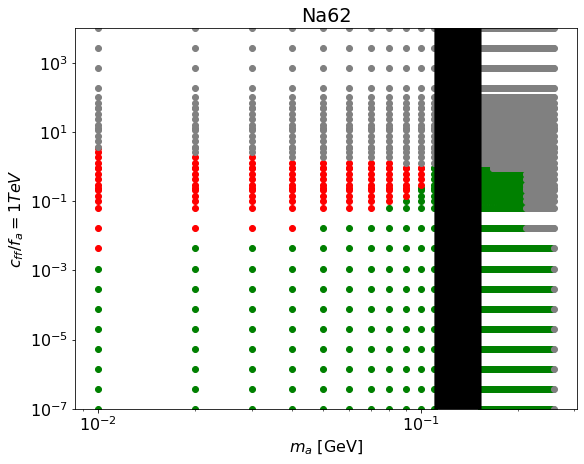

In [226]:
plt.figure(figsize=(9, 7))


# plotAllAllowed("output/m-tau-c-BRKtoPia-cff_combined.dat",0,2)
plotAllowedWCuts("output/m-tau-c-BRKtoPia-cff_combined.dat",0,2,1,mMin=0,mMax=260*10**-3,\
                 tauMin=100,tauMax=np.infty)

plotCutOutRegions(cutoutRegionsNa62,0.05,0.2,10**-7,10**5,3,color="black")

plt.title('Na62')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{ff}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.savefig('plots/Na62_cff_bound_new_form.png', dpi=300, bbox_inches='tight')

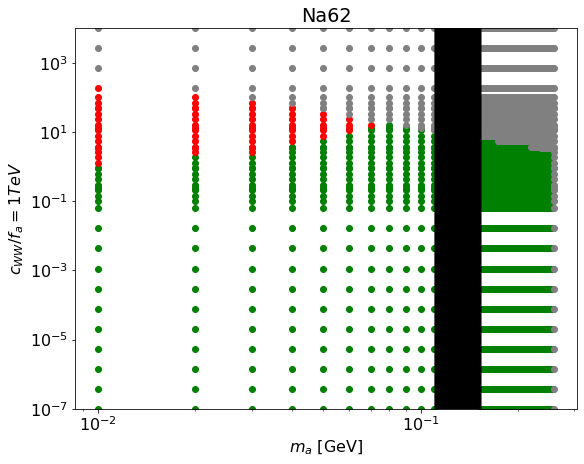

In [225]:
plt.figure(figsize=(9, 7))


# plotAllAllowed("output/m-tau-c-BRKtoPia-cWW_combined.dat",0,2)
plotAllowedWCuts("output/m-tau-c-BRKtoPia-cWW_combined.dat",0,2,1,mMin=0,mMax=260*10**-3,\
                 tauMin=100,tauMax=np.infty)

plotCutOutRegions(cutoutRegionsNa62,0.05,0.2,10**-7,10**5,3,color="black")

plt.title('Na62')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{WW}/f_a=1 TeV$')

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.xscale("log")
plt.yscale("log")

plt.savefig('plots/Na62_cWW_bound_new_form.png', dpi=300, bbox_inches='tight')

## BaBar

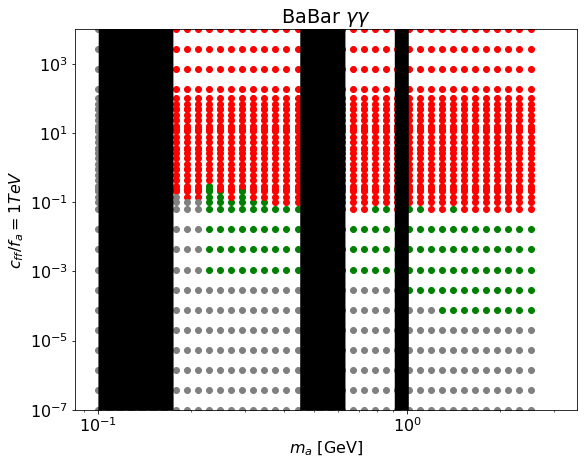

In [224]:
plt.figure(figsize=(9, 7))


# plotAllAllowed("output/m-tau-c-BRBtoKgammagamma-cff_combined.dat",0,2)
plotAllowedWCuts("output/m-tau-c-BRBtoKgammagamma-cff_combined.dat",0,2,1,mMin=0.175,mMax=4.78,\
                 tauMin=0,tauMax=100/sm['c']*10**12)

plotCutOutRegions(cutoutRegionsBaBargammagamma,0.1,3,10**-7,10**5,2,color="black")

plt.title('BaBar $\gamma \gamma$')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{ff}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.savefig('plots/BaBar-gammagamma_cff_bound_new_form.png', dpi=300, bbox_inches='tight')

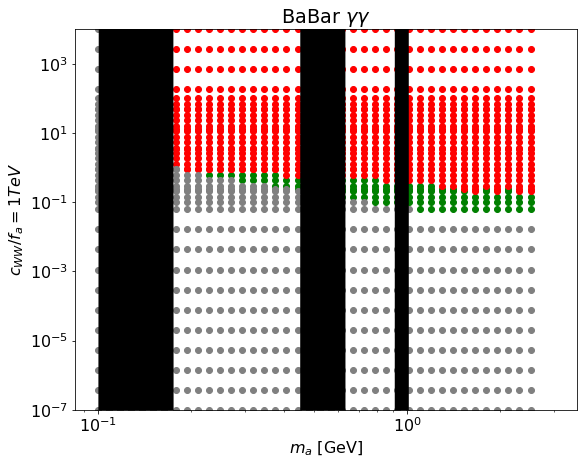

In [223]:
plt.figure(figsize=(9, 7))


# plotAllAllowed("output/m-tau-c-BRBtoKgammagamma-cWW_combined.dat",0,2)
plotAllowedWCuts("output/m-tau-c-BRBtoKgammagamma-cWW_combined.dat",0,2,1,mMin=0.175,mMax=4.78,\
                 tauMin=0,tauMax=100/sm['c']*10**12)

plotCutOutRegions(cutoutRegionsBaBargammagamma,0.1,3,10**-7,10**5,2,color="black")

plt.title('BaBar $\gamma \gamma$')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{WW}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.savefig('plots/BaBar-gammagamma_cWW_bound_new_form.png', dpi=300, bbox_inches='tight')

## KOTO

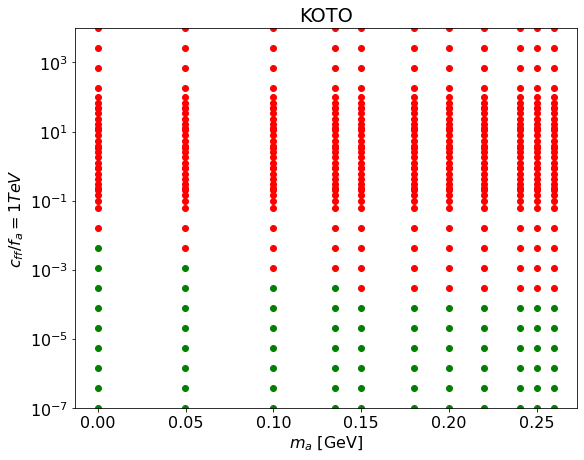

In [74]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-BRKLtoPi0a-cff_combined.dat",0,2)
#plotWhiteRegions(10**(3))

# plotWhiteRegions(10**5)

plt.title('KOTO')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{ff}/f_a=1 TeV$')
# plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.savefig('plots/KOTO_cff_bound_new_form.png', dpi=300, bbox_inches='tight')

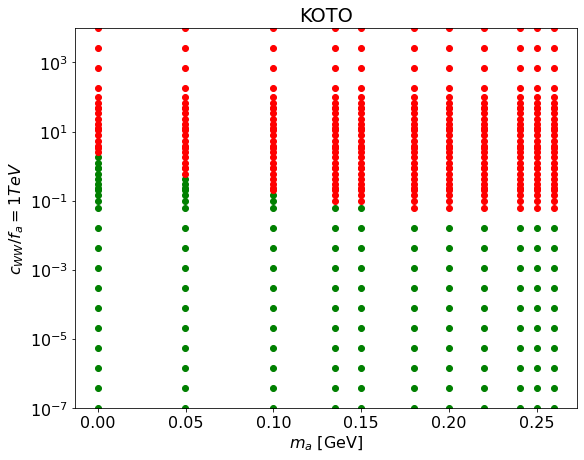

In [73]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-BRKLtoPi0a-cWW_combined.dat",0,2)
#plotWhiteRegions(10**(3))

# plotWhiteRegions(10**5)

plt.title('KOTO')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{WW}/f_a=1 TeV$')
# plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.savefig('plots/KOTO_cWW_bound_new_form.png', dpi=300, bbox_inches='tight')

## NuCal + CHARM

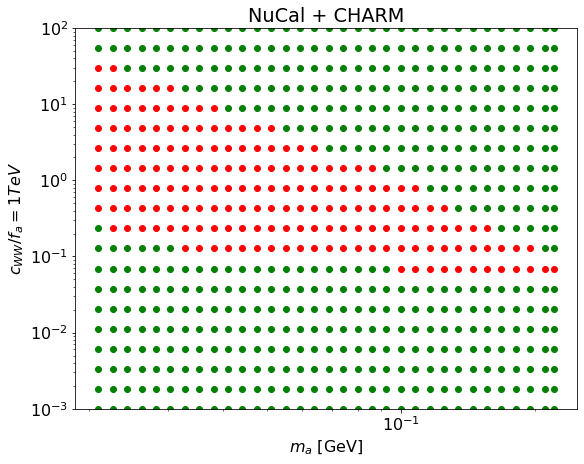

In [222]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-NuCal-CHARM-cWW_combined.dat",0,2)
#plotWhiteRegions(10**(3))

# plotWhiteRegions(10**5)

plt.title('NuCal + CHARM')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{WW}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-3, 10**2)

plt.savefig('plots/NuCal-CHARM_cWW_bound.png', dpi=300, bbox_inches='tight')

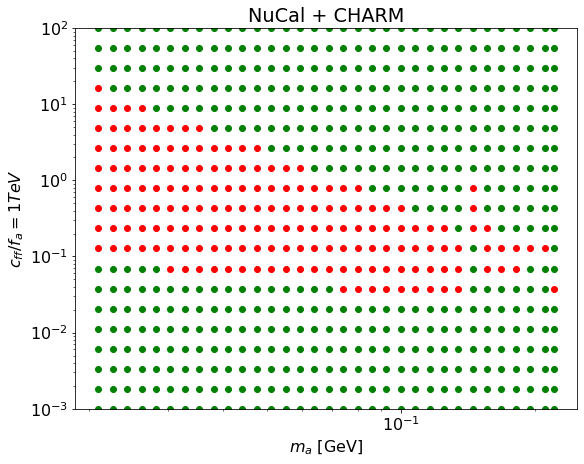

In [221]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-NuCal-CHARM-cff_combined.dat",0,2)
#plotWhiteRegions(10**(3))

# plotWhiteRegions(10**5)

plt.title('NuCal + CHARM')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{ff}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-3, 10**2)

plt.savefig('plots/NuCal-CHARM_cff_bound.png', dpi=300, bbox_inches='tight')

## NuCal + CHARM + E137

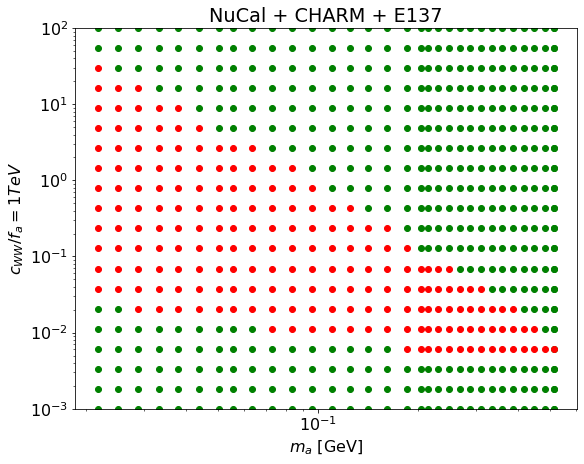

In [220]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-NuCal-CHARM-E137-cWW_combined.dat",0,2)
#plotWhiteRegions(10**(3))

# plotWhiteRegions(10**5)

plt.title('NuCal + CHARM + E137')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{WW}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-3, 10**2)

plt.savefig('plots/NuCal-CHARM-E137_cWW_bound.png', dpi=300, bbox_inches='tight')

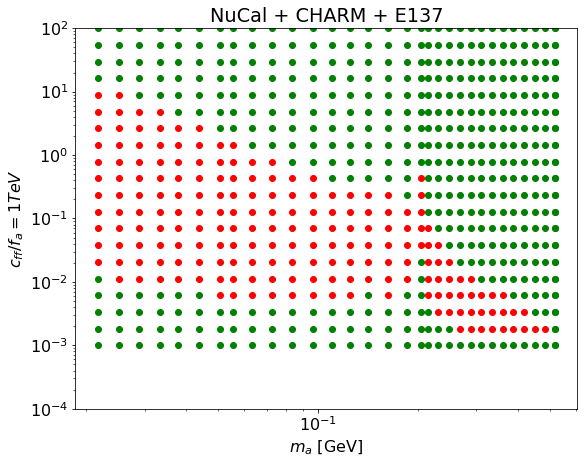

In [219]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-NuCal-CHARM-E137-cff_combined.dat",0,2)
#plotWhiteRegions(10**(3))

# plotWhiteRegions(10**5)

plt.title('NuCal + CHARM + E137')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{ff}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-4, 10**2)

plt.savefig('plots/NuCal-CHARM-E137_cff_bound.png', dpi=300, bbox_inches='tight')